In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests as rqs
from bs4 import BeautifulSoup
from IPython.display import clear_output
from time import sleep
from datetime import datetime

In [7]:
def single_team(df) :
    if len(df) == 1: # If player played for a single team, do nothing
        return df
    else: # If player has moved, return total stats with last team
        row = df[df['Tm'] == 'TOT'].copy()
        row['Tm'] = [str(df['Tm'].iloc[-1])]
        return row

def SoRareScore(df):

    df = df.apply(pd.to_numeric, errors = 'ignore')
    scores = []
    for pts, reb, ast, blk, stl, tov, fg_3 in zip(df['PTS'], df['TRB'], df['AST'], df['BLK'], df['STL'], df['TOV'], df['3P']) :
        
        score = 0
        if pts not in ['Inactive', 'Did Not Play', 'Did Not Dress', 'Not With Team', 'Player Suspended']:
            
            pts, reb, ast, blk, stl, tov, fg_3 = int(pts), int(reb), int(ast), int(blk), int(stl), int(tov), int(fg_3)

            score = 1 * pts + 1.2 * reb + 1.5 * ast + 3 * blk + 3 * stl + 1 * fg_3 - 2 * tov

            doubles = 0 # Count double-digits stats
            if pts >= 10 :
                doubles += 1
            if reb >= 10 :
                doubles += 1
            if ast >= 10 :
                doubles += 1
            if blk >= 10 :
                doubles += 1
            if stl >= 10 :
                doubles += 1

            if doubles == 2 : # Double-double
                score += 1

            if doubles >= 3 : # Tripe-double
                score += 2
        
        else :
            score = 'dnp'

        scores.append(score)
    return scores

def mins_played(str) :
    min, sec = str.split(':')
    return float(min) + float(sec) / 60
                     

In [34]:
# Engineer the training set
def game_logs(year) :

    # Get player data for looped year
    url = f'https://www.basketball-reference.com/leagues/NBA_{year}_per_game.html'
    page = rqs.get(url)
    soup = BeautifulSoup(page.content, 'html')
    while soup.find('tr', class_ = 'thead') is not None :
        soup.find('tr', class_ = 'thead').decompose()
    table = soup.find('table')
    data = pd.read_html(str(table))[0][['Player', 'Tm', 'MP', 'G']]
    # Get the list of hrefs of players of looped year
    hrefs = []
    for x in table.find_all('a', href = True):
        if x['href'].split('/')[1] == 'players' :
            hrefs.append(x['href'][:-5])
    data['href'] = hrefs
    data = data.groupby('Player').apply(single_team).reset_index(drop = True)
    data = data[(data['MP'] >= 10) & (data['G'] >= 25)]

    player_df = []
    count = 1
    for player, href in zip(data['Player'], data['href']) :
        sleep(1.5)
        print(f'{year}: {count}/{len(data)} ... {player}')
        # Get looped player game log
        url = f'https://www.basketball-reference.com{href}/gamelog/{year}'
        page = rqs.get(url)
        soup = BeautifulSoup(page.content, 'html')
        while soup.find('tr', class_ = 'thead') is not None :
            soup.find('tr', class_ = 'thead').decompose()
        table = soup.find('table', id = 'pgl_basic')
        df = pd.read_html(str(table))[0][['Date', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]

        df.insert(0, 'Player', [player] * len(df)) # Insert player name
        df = df.apply(pd.to_numeric, errors = 'ignore')
        df['SORARE'] = SoRareScore(df) # Calculate SoRare score
        # Append player game logs to list
        player_df.append(df)
        count += 1
        clear_output(wait = True)

    return pd.concat(player_df)

In [36]:
game_logs_2021 = game_logs(2021)

2021: 380/380 ... Zion Williamson


In [38]:
game_logs_2021.to_csv('game_logs_2021.csv', index = None)

In [49]:
data_train = []
for year in [2021, 2022]:
    data_train.append(pd.read_csv(f'game_logs_{year}.csv'))
data_train = pd.concat(data_train)
data_train['Date'] = data_train['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))
data_train['Year'] = [str(date)[:4] for date in data_train.Date]
data_train.head()

,Player,Date,Tm,G,MP,PTS,TRB,AST,BLK,STL,TOV,3P,SORARE,Year
0,Aaron Gordon,2020-12-23,ORL,1.0,26:00,20,7,0,0,4,2,1,37.4,2020
1,Aaron Gordon,2020-12-26,ORL,2.0,29:39,15,9,3,0,0,0,1,31.299999999999997,2020
2,Aaron Gordon,2020-12-27,ORL,3.0,19:48,4,6,0,0,0,0,0,11.2,2020
3,Aaron Gordon,2020-12-29,ORL,4.0,22:10,12,5,2,1,1,3,0,21.0,2020
4,Aaron Gordon,2020-12-31,ORL,5.0,20:49,6,3,1,2,0,2,0,13.100000000000001,2020


In [50]:
def feature_engineering(df) :
    df = df.sort_values('Date')
    df['SORARE'] = df['SORARE'].replace('dnp', np.nan)
    df['PTS'] = df['PTS'].replace('Inactive', np.nan).replace('Did Not Play', np.nan).replace('Did Not Dress', np.nan).replace('Player Suspended', np.nan).replace('Not With Team', np.nan)

    df['form_1'] = [np.nan] + list(df['SORARE'].rolling(1).mean())[:-1]
    df['form_2'] = [np.nan] + list(df['SORARE'].rolling(2).mean())[:-1]
    df['form_5'] = [np.nan] + list(df['SORARE'].rolling(5, min_periods = 3).mean())[:-1]
    df['form_10'] = [np.nan] + list(df['SORARE'].rolling(10, min_periods = 5).mean())[:-1]
    df['mean_score'] = [np.nan] + list(df['SORARE'].rolling(25, min_periods = 1).mean())[:-1]

    df['Rest'] = [np.nan] + [(t1 - t0).days for t1, t0 in zip(df.Date[1:], df.Date[:-1])]
  #  df['MP_5'] = [np.nan] + list(df['MP'].rolling(5, min_periods = 1).mean())[:-1]
   # df['MP_mean'] = [np.nan] + list(df['MP'].rolling(100, min_periods = 1).mean())[:-1]

    return df

data_train = data_train.groupby(['Player', 'Year']).apply(feature_engineering)
data_train = data_train[data_train['SORARE'].notna()]


data_train.head()

,Player,Date,Tm,G,MP,PTS,TRB,AST,BLK,STL,TOV,3P,SORARE,Year,form_1,form_2,form_5,form_10,mean_score,Rest
0,Aaron Gordon,2020-12-23,ORL,1.0,26:00,20,7,0,0,4,2,1,37.4,2020,NaN,NaN,NaN,NaN,NaN,NaN
0,Aaron Gordon,2021-10-20,DEN,1.0,29:01,12,8,4,1,0,3,1,25.6,2021,4.4,NaN,22.233333,18.15,21.713043,157.0
1,Aaron Gordon,2020-12-26,ORL,2.0,29:39,15,9,3,0,0,0,1,31.299999999999997,2020,37.4,NaN,NaN,NaN,37.400000,3.0
1,Aaron Gordon,2021-10-22,DEN,2.0,29:49,8,5,1,0,0,3,0,9.5,2021,25.6,15.00,23.075000,18.55,20.904348,2.0
2,Aaron Gordon,2020-12-27,ORL,3.0,19:48,4,6,0,0,0,0,0,11.2,2020,31.3,34.35,NaN,NaN,34.350000,1.0


In [7]:
print(data_train.shape)
data_train = data_train[(data_train['form_1'].notna()) & (data_train['form_2'].notna()) & (data_train['form_5'].notna()) & (data_train['form_10'].notna()) & (data_train['mean_score'].notna())]
print(data_train.shape)
data_train.head()

(26038, 21)
(17487, 21)


,Player,Date,Tm,G,MP,PTS,TRB,AST,BLK,STL,...,3P,SORARE,form_1,form_2,form_5,form_10,mean_score,Rest,MP_5,MP_mean
5,Aaron Gordon,2021-10-30,DEN,6.0,31.200000,12,4,2,2,2,...,0,31.8,25.0,26.45,21.46,21.460000,21.460000,1.0,28.926667,28.926667
6,Aaron Gordon,2021-11-01,DEN,7.0,28.250000,15,10,1,0,0,...,2,29.5,31.8,28.40,22.70,23.183333,23.183333,2.0,29.363333,29.305556
7,Aaron Gordon,2021-11-03,DEN,8.0,30.033333,9,1,1,2,0,...,1,16.7,29.5,30.65,26.70,24.085714,24.085714,2.0,29.050000,29.154762
8,Aaron Gordon,2021-11-06,DEN,9.0,27.700000,9,3,2,2,0,...,3,22.6,16.7,23.10,26.18,23.162500,23.162500,3.0,29.440000,29.264583
9,Aaron Gordon,2021-11-08,DEN,10.0,36.300000,10,7,3,1,0,...,0,19.9,22.6,19.65,25.12,23.100000,23.100000,2.0,28.153333,29.090741


mae : 8.417000720353164


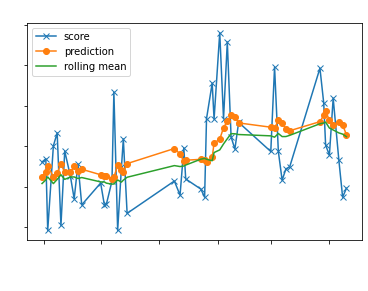

In [8]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import Ridge

features = ['form_2', 'form_5', 'mean_score', 'Rest', 'MP_5', 'MP_mean']

train_play, test_play = train_test_split(list(set(data_train.Player)), test_size = 0.1)

X_train = data_train[data_train['Player'].isin(train_play)]
X_test = data_train[data_train['Player'].isin(test_play)]

model = LinearRegression()
#model = RandomForestRegressor()
model = Ridge(1.0)
model.fit(X_train[features], X_train['SORARE'])

X_test = X_test.assign(pred = model.predict(X_test[features]))

print('mae :', mean_absolute_error(X_test.SORARE, X_test.pred))

play = X_test.Player.iloc[np.random.randint(len(X_test))]
player_test = X_test.groupby('Player').get_group(play).sort_values('Date')
plt.plot(player_test.Date, player_test['SORARE'].astype(float), label = 'score', marker = 'x')
plt.plot( player_test.Date, player_test.pred, label = 'prediction', marker = 'o')
plt.plot( player_test.Date, player_test.mean_score, label = 'rolling mean')
plt.title(play, color = 'white')
plt.xticks(color = 'white', rotation = 45)
plt.yticks(color = 'white')
plt.legend()
plt.show()


In [30]:
# Engineer the training set
url = f'https://www.basketball-reference.com/leagues/NBA_2023_per_game.html'
page = rqs.get(url)
soup = BeautifulSoup(page.content, 'html')
while soup.find('tr', class_ = 'thead') is not None :
    soup.find('tr', class_ = 'thead').decompose()

table = soup.find('table')

data_live = pd.read_html(str(table))[0][['Player', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]
hrefs = []
for x in table.find_all('a', href = True):
    if x['href'].split('/')[1] == 'players' :
        hrefs.append(x['href'][:-5])
data_live['href'] = hrefs
data_live = data_live.groupby('Player').apply(single_team)
data_live = data_live.reset_index(drop = True)

data_live.sort_values('PTS', ascending = False).head(10)

,Player,Tm,G,MP,PTS,TRB,AST,BLK,STL,TOV,3P,href
95,Luka Dončić,DAL,4,35.8,36.3,9.5,9.3,0.8,2.0,3.8,2.5,/players/d/doncilu01
10,Giannis Antetokounmpo,MIL,4,35.3,34.5,13.3,6.3,1.8,0.8,3.5,1.3,/players/a/antetgi01
103,Kevin Durant,BRK,5,37.2,33.2,4.4,4.0,1.8,0.6,3.6,1.8,/players/d/duranke01
274,Ja Morant,MEM,5,32.8,32.6,4.4,6.8,0.6,0.8,3.4,2.6,/players/m/moranja01
375,Jayson Tatum,BOS,5,38.2,32.4,8.0,3.6,1.2,0.8,2.2,3.0,/players/t/tatumja01
267,Donovan Mitchell,CLE,5,39.4,31.0,4.8,6.4,0.2,1.8,4.2,3.4,/players/m/mitchdo01
227,Damian Lillard,POR,5,35.0,31.0,4.8,4.6,0.4,0.8,3.8,4.0,/players/l/lillada01
81,Stephen Curry,GSW,5,33.4,30.8,6.0,6.0,0.2,1.4,2.6,5.4,/players/c/curryst01
117,De'Aaron Fox,SAC,4,34.8,30.5,5.8,5.8,0.5,1.3,4.3,2.8,/players/f/foxde01
181,Kyrie Irving,BRK,5,39.0,29.6,5.4,4.4,1.4,1.6,2.2,2.4,/players/i/irvinky01


In [33]:
my_players = ['Nikola Jokić', 'Jaylen Brown']

In [40]:
def my_teams(my_players, data, model) :

    my_data = data_live[data_live['Player'].isin(my_players)]

    player_df = []
    for player, href in zip(my_data['Player'], my_data['href']) :

        url = f'https://www.basketball-reference.com{href}/gamelog/2023'

        page = rqs.get(url)
        soup = BeautifulSoup(page.content, 'html')
        while soup.find('tr', class_ = 'thead') is not None :
            soup.find('tr', class_ = 'thead').decompose()

        table = soup.find('table', id = 'pgl_basic')
        df = pd.read_html(str(table))[0][['Date', 'Tm', 'G', 'MP', 'PTS', 'TRB', 'AST', 'BLK', 'STL', 'TOV', '3P']]
        df.insert(0, 'Player', len(df) * [player])
        df = df.apply(pd.to_numeric, errors = 'ignore')
        df['SORARE'] = SoRareScore(df)
        df['Date'] = df['Date'].apply(lambda x: datetime.strptime(x, '%Y-%m-%d'))

        player_df.append(df)

    my_data = pd.concat(player_df)

    return my_data

In [44]:
dic = my_teams(my_players, data_live, model)

In [45]:
dic = dic.groupby('Player').apply(form)
dic = dic.groupby('Player').apply(rest)
dic = dic[dic['SORARE'].notna()]
dic['MP'] = dic['MP'].apply(mins_played)
dic = dic.groupby('Player').apply(mins_rolling)
dic

,Player,Date,Tm,G,MP,PTS,TRB,AST,BLK,STL,...,3P,SORARE,form_1,form_2,form_5,form_10,mean_score,Rest,MP_5,MP_mean
0,Jaylen Brown,2022-10-18,BOS,1,38.566667,35,3,2,1,2,...,4,46.6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Jaylen Brown,2022-10-21,BOS,2,34.016667,28,4,3,2,2,...,2,45.3,46.6,NaN,NaN,NaN,46.600000,3.0,38.566667,38.566667
2,Jaylen Brown,2022-10-22,BOS,3,37.500000,12,9,4,1,1,...,1,31.8,45.3,45.95,NaN,NaN,45.950000,1.0,36.291667,36.291667
3,Jaylen Brown,2022-10-24,BOS,4,35.383333,21,6,2,2,0,...,2,37.2,31.8,38.55,41.233333,NaN,41.233333,2.0,36.694444,36.694444
4,Jaylen Brown,2022-10-28,BOS,5,42.800000,32,8,4,0,2,...,2,43.6,37.2,34.50,40.225000,NaN,40.225000,4.0,36.366667,36.366667
0,Nikola Jokić,2022-10-19,DEN,1,33.416667,27,4,6,0,3,...,1,44.8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,Nikola Jokić,2022-10-21,DEN,2,34.400000,26,12,10,0,0,...,1,48.4,44.8,NaN,NaN,NaN,44.800000,2.0,33.416667,33.416667
2,Nikola Jokić,2022-10-22,DEN,3,38.683333,19,16,13,1,1,...,1,60.7,48.4,46.60,NaN,NaN,46.600000,1.0,33.908333,33.908333
3,Nikola Jokić,2022-10-24,DEN,4,26.966667,9,9,9,0,0,...,0,31.3,60.7,54.55,51.300000,NaN,51.300000,2.0,35.500000,35.500000
4,Nikola Jokić,2022-10-26,DEN,5,34.800000,31,13,9,0,4,...,0,67.1,31.3,46.00,46.300000,NaN,46.300000,2.0,33.366667,33.366667
